<h4>Melbourne Data - Kaggle</h4>

This is a notebook tackling the learning at https://www.kaggle.com/code/dansbecker/basic-data-exploration

Machine learning takes patterns from data sets to compute predictions - because these computations are done by machines, they can be done at huge sale across many varied data points.

At very simplistic level, the example of decision trees predicting house prices is valid.

This simple decision tree has identified from data sets that if a house has more than 2 bedrooms, it will be valued at £188,000.  If it has less, it will be valued at £178,000

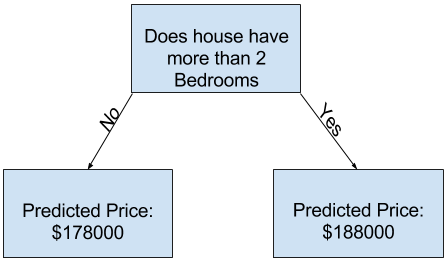

The process of capturing patterns from data is called fitting or training, and the data used to achieve this is called training data.

The more data, the more potential patterns can be identified.

Here, the decision tree is expanded to encompass data that speaks to number of bedrooms and size of the plot of land the house is on.

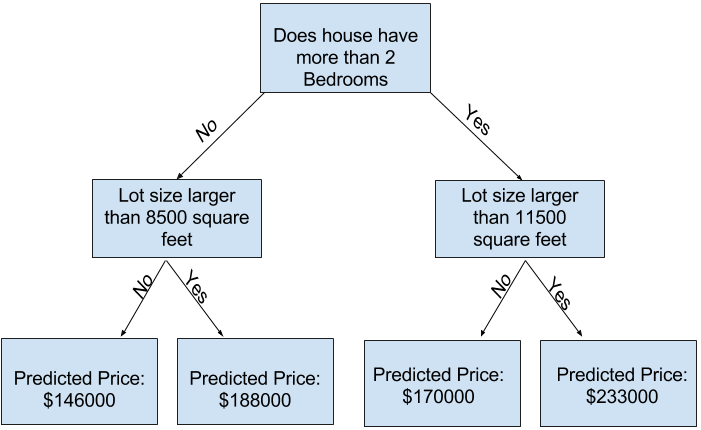



In [3]:
import pandas as pd 
pd.options.display.float_format = '{:,.2f}'.format # rounding float values to 2 decimal places

In [4]:
# we will load the Melbourne housing dataset from a CSV file and use it to demonstrate some basic data exploration and model building techniques.

file_path = "C:\\Users\\UserPC\\Desktop\\my_folder\\Learning alongside DProf\\kaggle and LinkedIn\\datasets\\melb_data.csv"
melb_data = pd.read_csv(file_path)
melb_data.shape # 13,580 rows of data and 21 columns


(13580, 21)

In [6]:
# identify columns with missing data

missing_counts = melb_data.isnull().sum() # count of missing values per column
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False) # filter to columns with missing data only
missing_percent = (melb_data.isnull().mean() * 100).loc[missing_counts.index].round(2) # percentage of missing data per column
missing_summary = pd.concat([missing_counts, missing_percent], axis=1) # combine counts and percentages
missing_summary.columns = ['missing_count', 'missing_percent'] # rename columns
print(missing_summary)

              missing_count  missing_percent
BuildingArea           6450            47.50
YearBuilt              5375            39.58
CouncilArea            1369            10.08
Car                      62             0.46


In [7]:
# drop rows with missing data (crude method but works for demonstration)

melb_data = melb_data.dropna(axis = 0)
melb_data.shape # 6195 rows and 21 columns remain after dropping rows with missing data.


(6196, 21)

In [8]:
# identify the target variable

y = melb_data.Price

In [9]:
# identify the features we will use to predict the target variable

features = ["Rooms", "Bathroom", "Landsize", "BuildingArea",
            "YearBuilt", "Lattitude", "Longtitude"]

X = melb_data[features]

In [10]:
# spcify the model we will use (decision tree regressor)

from sklearn.tree import DecisionTreeRegressor # type: ignore
model = DecisionTreeRegressor(random_state = 1)

# fit the model to the training data
model.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [12]:
# make predictions for the first 5 houses in the dataset

print("The price predictions for the first 5 houses are:")
print(model.predict(X.head()))

The price predictions for the first 5 houses are:
[1035000. 1465000. 1600000. 1876000. 1636000.]


This is initially nonsense as we've taken a model and trained it on the data set entire meaning it's memorised the y values and is accurate to those price values.

In practice, we need to split data into train and validation sets and work to validate these predictions.

One way is using Mean Absolute Error which is the average of all actual prices minus the predicted prices i.e the average of all (error = actual - predicted).

In [15]:
# import mean absolute error metric and calculate MAE for our model's predictions
from sklearn.metrics import mean_absolute_error # type: ignore

# make predictions for all houses in the dataset
predicted_home_values = model.predict(X)
mae = mean_absolute_error(y, predicted_home_values)
print("The mean absolute error of our predictions is:")
print(f"${round(mae, 2)}")

The mean absolute error of our predictions is:
$62504.28


Again, this is meaningless as the data fits the whole data set and has not been split / validated etc.

Accordingly, we need a process where we split our data sets into training and validation sets - we train the model on the training data and we validate the accuracy of the model on the validation data.  This can be done programmatically (note here we already reduced our data set from approx. 13k rows to approx. 6k rows and we've now split it into training and validation sets).

In [17]:
from sklearn.model_selection import train_test_split # type: ignore

# split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

# specify the model
model = DecisionTreeRegressor()

# fit the model to the training data
model.fit(train_X, train_y)

# make predictions on the validation data
validated_predictions = model.predict(val_X)

print("Making predictions for the first five 5 houses in the validation data set:")
print("The price predictions are:")
print(model.predict(val_X.head())) # predictions for first 5 houses in validation set

print("\nThe actual values are:")
print(val_y.head().tolist()) # converting the head() display to a list

print("\nThe mean absolute error of our validated predictions is:")
print(f"${round(mean_absolute_error(val_y, validated_predictions), 2)}") # calculate MAE for validation predictions

Making predictions for the first five 5 houses in the validation data set:
The price predictions are:
[ 441700. 1720000.  650000.  920000. 4850000.]

The actual values are:
[620000.0, 2320000.0, 750000.0, 1120000.0, 6500000.0]

The mean absolute error of our validated predictions is:
$254385.89


The new MAE value is wildly larger than before and shows the model as not hugely performative!

Accordingly we need to adjust the model using variations of leaf node to establish if we can improve the MEA score and make the model more accurate.

When we use an algorithmic process such as a decision tree to develop a predictive model, it is possible to "under fit" or "over fit" the model.

With decision trees, the number of "decisions", known as leaves, the model makes with the training data can be controlled.

If we increase the number of decisions (i.e. number of leaves), the training data is split multiple times and decisions are made on increasingly small data sets.  This may lead to a process whereby the predictive model is incredibly accurate on the training data but wildly inaccurate on any validation data.  This is because the data points for the decisions have become vanishingly small that the model is now over fitted to the training data.

If we conversely keep the number of decisions small (leaf split is minimal) then decisions are made on data points without any granularity of distinction between them.  Accordingly, the model remains inaccurate and is under fitted.

The goal with a model is to find the sweet spot between the number of decisions needed and the model becoming over fitted.  This is represented in the graph;

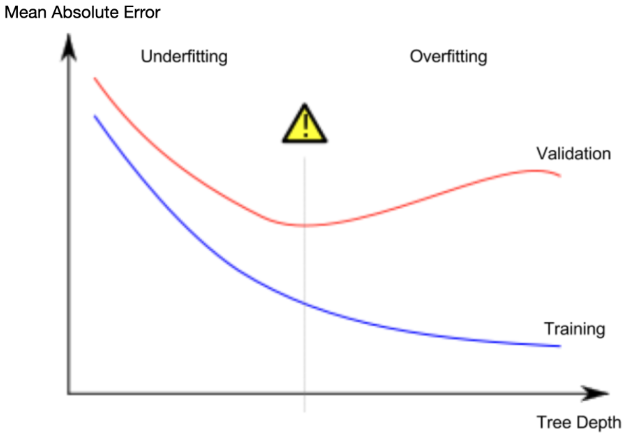

In [18]:
# create a function to compute MAE for different values of max_leaf_nodes

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state = 1) # specify the model with varied leaf nodes
    model.fit(train_X, train_y) # fit the model to the training data
    preds_val = model.predict(val_X) # make predictions on the validation data
    mae = mean_absolute_error(val_y, preds_val) # calculate MAE
    return mae # return the MAE value

In [19]:
# call the function with different values of max_leaf_nodes and storing each returned MAE value in a list

mae_list = [] # empty list to store MAE values
for max_leaf_nodes in [5, 50, 100, 500, 5000]: # loop over different leaf node values
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y) # call the function
    mae_list.append(my_mae) # append the returned MAE to the list
    print(f"Max leaf nodes: {max_leaf_nodes}\t\tMean Absolute Error: {round(my_mae, 2)}") # print the MAE for each leaf node value

best_node = round(min(mae_list))
print(f"\nThe most accurate MAE: {best_node}")

Max leaf nodes: 5		Mean Absolute Error: 324110.91
Max leaf nodes: 50		Mean Absolute Error: 248796.26
Max leaf nodes: 100		Mean Absolute Error: 238658.4
Max leaf nodes: 500		Mean Absolute Error: 239296.13
Max leaf nodes: 5000		Mean Absolute Error: 251539.96

The most accurate MAE: 238658


In [ ]:
# reconstruct the tested leaf-node choices and find the best MAE index/value
nodes = [5, 50, 100, 500, 5000]
best_idx = mae_list.index(min(mae_list))
best_node = nodes[best_idx]
best_mae_value = mae_list[best_idx]

print(f"Best index position: {best_idx}")
print(f"Corresponding max_leaf_nodes (index value): {best_node}")
print(f"MAE at that position: {round(best_mae_value, 2)}")


Here's the takeaway: Models can suffer from either:

__Overfitting__: capturing spurious patterns that won't recur in the future, leading to less accurate predictions, 
or
__Underfitting__: failing to capture relevant patterns, again leading to less accurate predictions.

We use validation data, which isn't used in model training, to measure a candidate model's accuracy. This lets us try various models and keep the best one.

Below is the process fresh with a new data set.

In [21]:
# loading fresh data for further model testing

house_data_path = "C:\\Users\\UserPC\\Desktop\\my_folder\\Learning alongside DProf\\kaggle and LinkedIn\\datasets\\train_data_housing.csv"
house_data = pd.read_csv(house_data_path)

y = house_data.SalePrice # defining our target variable

features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd'] # now defining our features
X = house_data[features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1) # splitting the data into training and validation sets

house_model = DecisionTreeRegressor(random_state = 1) # specifying the model
house_model.fit(train_X, train_y) # fitting the model
house_predictions = house_model.predict(val_X) # making predictions
house_mae = mean_absolute_error(val_y, house_predictions) # evaluating the model using MAE
print(f"Baseline Decision Tree (untuned) MAE: ${round(house_mae, 2)}\n")

testing_leaf_nodes = [5, 25, 50, 100, 250, 500] # defining different leaf node values to test
mae_values = [] # list to store MAE values

for node in testing_leaf_nodes: # calling the get_mae function for different leaf nodes
    mae = get_mae(node, train_X, val_X, train_y, val_y) 
    mae_values.append(mae)
    print(f"Max leaf nodes: {node}\t\tMean Absolute Error: ${round(mae,2)}")

best_node = testing_leaf_nodes[mae_values.index(min(mae_values))] # identifying the best node (the node with the smallest MAE)
best_mae = min(mae_values)
print(f"\nThe best max_leaf_nodes is {best_node} with MAE ${round(best_mae,2)}")

final_model = DecisionTreeRegressor(max_leaf_nodes = best_node, random_state = 1) # final model with best leaf nodes

final_model.fit(train_X, train_y)  # fitting the final model on the training dataset
final_predictions = final_model.predict(val_X)

final_mae = mean_absolute_error(val_y, final_predictions) # defining the final MAE

print(f"\nOptimized model MAE: ${round(final_mae, 2)}")
print(f"\nImprovement: ${round(house_mae - final_mae, 2)}")


Baseline (untuned) MAE: $29652.93

Max leaf nodes: 5		Mean Absolute Error: $35044.51
Max leaf nodes: 25		Mean Absolute Error: $29016.41
Max leaf nodes: 50		Mean Absolute Error: $27405.93
Max leaf nodes: 100		Mean Absolute Error: $27282.51
Max leaf nodes: 250		Mean Absolute Error: $27430.85
Max leaf nodes: 500		Mean Absolute Error: $28357.63

The best max_leaf_nodes is 100 with MAE $27282.51

Optimized model MAE: $27282.51

Improvement: $2370.42
